# Solve viscous Burgers equation with SWIM-ODE:
In this script we show how SWIM-ODE uses resampling of collocation points and data-dependant sampling of weights and biases to solve Burgers equation accurately

In [1]:
import sys
sys.path.append('../../')
sys.path.append('../../src')
from swimpde import Domain
from swimpde import BasicAnsatz
from swimpde import BurgersSolver
import numpy as np
import scipy
from sklearn.metrics import mean_squared_error
from matplotlib import ticker
import time
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'jet'

### Load data and reference solution

In [2]:
# Load and visualize data
data = scipy.io.loadmat('../../data/burgers_shock.mat')
t_eval = data['t'].flatten()[:,None]
x_eval = data['x'].flatten()[:,None]
u_exact = np.real(data['usol']).T
X, T = np.meshgrid(x_eval,t_eval)
X_ = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Set ground truth
u_true = u_exact.flatten()[:,None]              

### Problem setup

In [3]:
# initial condition
def u0(x):
    return -1 * np.sin(np.pi * x)

# forcing
def forcing(x, t):
    return np.zeros(x.shape[0])

# boundary condition
boundary_condition = "zero dirichlet" # 

# Domain information and spacial points for the first time-block
n_points_1d = 4000 # No. of points in space
x_lim = [-1, 1] # Domain range

# Interior points
rng = np.random.default_rng(seed=123)
x_space = rng.uniform(x_lim[0], x_lim[1], n_points_1d).reshape((-1, 1)) 
x_space_inner = x_space[1:-1]
interior_points = x_space_inner

# Boundary points (excluding corners)
left = x_lim[0]
right = x_lim[1]
boundary_points = np.row_stack([left, right])

### Train and evaluate SWIM-ODE network

In [4]:
# Hyper-parameters
n_sample = 3000 # No. of sampling points (for computing gradients)
n_col = 800 # No. of collocation points (to be re-sampled)
width = 450 # Width
reg_const = 1e-7 # Regularization constant
svd_cutoff = 1e-9 # SVD threshold
seeds = [1,2,3] # Seeds (to compute mean errors)
time_blocks = 3 # Number of time-blocks for smapling
info = [] # List to store errors and time measurements

# Define prob. distribution for (re)-sampling collocation points
def collocation_points_probabilities(df_dx):
    gradients = np.abs(df_dx)
    gradients = gradients + 0.01 * np.max(gradients)
    return gradients/np.sum(gradients)

# Points where gradient of the solution at the end of a time-block is computed
sample_test_points = np.sort(rng.uniform(x_lim[0] + 1e-4, x_lim[1] - 1e-4, n_sample)).reshape((-1, 1)) # This does not include boundary points

# Domain
domain = Domain(
    interior_points=interior_points,
    boundary_points=boundary_points,
    sample_points = sample_test_points
)

# Store errors and time required for each seed
rel_err_swim = np.ones((len(seeds), ))
time_swim = np.ones((len(seeds), ))
rmse_swim = np.ones((len(seeds), ))
j = 0
for seed in seeds: # Run over 3 seeds                                    
    # SWIM network ansatz
    ansatz_swim = BasicAnsatz(
        n_neurons=width,
        activation="tanh",
        random_state=seed,
        regularization_scale=reg_const,
        parameter_sampler = "tanh" 
    )
    # Burgers equation solver
    burgers_solver_swim = BurgersSolver(
        domain=domain, 
        ansatz=ansatz_swim,
        u0=u0,
        boundary_condition=boundary_condition,
        forcing=forcing,
        regularization_scale=reg_const,
        c=(0.01/np.pi)
    )
    # SWIM fit
    t_swim_start = time.time()
    sol_swim, solver_status_swim = burgers_solver_swim.fit_time_blocks(t_span=[0, np.max(t_eval)], rtol=1e-8, atol=1e-8, svd_cutoff=svd_cutoff, time_blocks=time_blocks, prob_distr_resampling = collocation_points_probabilities, n_col=n_col, outer_basis=False);
    t_swim_stop = time.time()
    time_swim[j] = t_swim_stop - t_swim_start
    # Evaluate SWIM
    u_swim = (burgers_solver_swim.evaluate_blocks(x_eval= x_eval, t_eval = t_eval, time_blocks = time_blocks, solver_status = solver_status_swim)).T
    # Compute metrics
    mse_swim = mean_squared_error(u_true, u_swim.flatten()[:,None])  # mean squared error
    rmse_swim[j] = np.sqrt(mse_swim)  # Root Mean Squared Error                  
    rel_err_swim[j] = np.linalg.norm(u_true-u_swim.flatten()[:,None],2)/np.linalg.norm(u_true,2) # Relative l-2 error
    print("rmse_swim, re_swim")
    print(rmse_swim[j], rel_err_swim[j])
    j += 1

# RMSE and relative l-2 errors (mean and std) and time measurements
info.append(np.mean(time_swim))
info.append(np.mean(rmse_swim))
info.append(np.std(rmse_swim))
info.append(np.mean(rel_err_swim))
info.append(np.std(rel_err_swim))


c:\PhD\Work\Programming\swim_pde_paper\swimpde-paper\swimpde\examples\burgers\../../src\swimpde\Solver\burgers_solver.py:144: RuntimeWarning: overflow encountered in multiply
  non_lin_term =  t1 * t2
c:\PhD\Work\Programming\swim_pde_paper\swimpde-paper\swimpde\examples\burgers\../../src\swimpde\Solver\burgers_solver.py:153: RuntimeWarning: invalid value encountered in matmul
  c_t = self._A_boundary_inv @ np.concatenate([rhs, self.scale_boundary_correction * boundary_correction])


rmse_swim, re_swim
0.0006080909977263369 0.0009898321100579146
rmse_swim, re_swim
4.064199834080494e-06 6.61558140558983e-06


c:\PhD\Work\Programming\swim_pde_paper\swimpde-paper\swimpde\examples\burgers\../../src\swimpde\Solver\burgers_solver.py:144: RuntimeWarning: overflow encountered in multiply
  non_lin_term =  t1 * t2
c:\PhD\Work\Programming\swim_pde_paper\swimpde-paper\swimpde\examples\burgers\../../src\swimpde\Solver\burgers_solver.py:153: RuntimeWarning: invalid value encountered in matmul
  c_t = self._A_boundary_inv @ np.concatenate([rhs, self.scale_boundary_correction * boundary_correction])


rmse_swim, re_swim
3.0048800977784118e-06 4.8912528203444845e-06


### Errors and time measurements

In [5]:
# Print errors and time measurements for Burgers with ODE-SWIM
res = np.vstack(info).reshape(-1)

# Burgers time measurements
print('Burgers equation: Errors and time measurements using ODE-SWIM')
print('training time for swim = ', res[-5])
print('rmse swim = ', res[-4], '+-', res[-3])
print('rel error swim = ', res[-2], '+-', res[-1])

Burgers equation: Errors and time measurements using ODE-SWIM
training time for swim =  360.7527981599172
rmse swim =  0.00020505335921939863 +- 0.00028499097538871066
rel error swim =  0.0003337796480946163 +- 0.0004638996787836397


### Error plots and comparison of solutions

Relative L2 error on the entire spatio-temporal domain: 4.891253e-06


C:\Users\chinm\AppData\Local\Temp\ipykernel_32156\1003889938.py:82: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


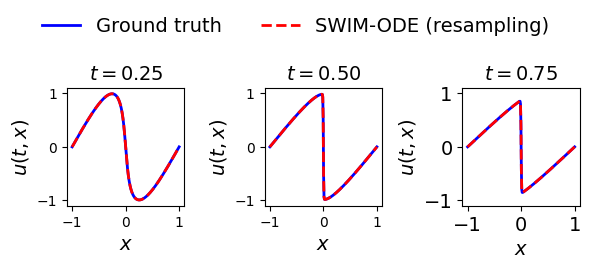

In [6]:
# True and model solutions
u_true_test = u_exact
u_model_test = u_swim

# Relative l-2 error
error_u = np.linalg.norm(u_true-u_model_test.flatten()[:,None]  ,2)/np.linalg.norm(u_true,2)
print('Relative L2 error on the entire spatio-temporal domain: %e' % (error_u))

# visualize the solution
fontsize = 14
fig, ax = plt.subplots(1, 3, figsize=(6, 3), constrained_layout=True)
extent = [0 , 1, np.min(x_space), np.max(x_space)]
aspect = 0.3
sol_img1 = ax[0].imshow(u_true_test.T, extent=extent, origin='lower', aspect=aspect)#, vmin=vlim[0], vmax=vlim[1]
sol_img2 = ax[1].imshow(u_model_test.T, extent=extent, origin='lower', aspect=aspect)#, vmin=vlim[0], vmax=vlim[1]
error_img = ax[2].imshow(abs(u_model_test - u_true_test).T,  extent=extent, origin='lower', aspect=aspect)

ax[0].set_xlabel('t', fontsize = fontsize)
ax[1].set_xlabel('t', fontsize = fontsize)
ax[2].set_xlabel('t', fontsize = fontsize)
ax[0].set_ylabel('x', fontsize = fontsize)

ax[0].axvline(x=0.25, color='k', linestyle='--', linewidth=2)
ax[0].axvline(x=0.5, color='k', linestyle='--', linewidth=2)
ax[0].axvline(x=0.75, color='k', linestyle='--', linewidth=2)

ax[1].axvline(x=0.33, color='gray', linestyle='dotted', linewidth=3)
ax[1].axvline(x=0.66, color='gray', linestyle='dotted', linewidth=3)

cbar_true = fig.colorbar(sol_img1, ax=ax[0], location='bottom')
cbar_swim = fig.colorbar(sol_img2, ax=ax[1], location='bottom')
cbar_err = fig.colorbar(error_img, ax=ax[2], location='bottom', format='%.0e', fraction=0.046)

tick_locator_err = ticker.MaxNLocator(nbins=2)
cbar_err.locator = tick_locator_err
cbar_err.update_ticks()

tick_locator_swim = ticker.MaxNLocator(nbins=2)
cbar_swim.locator = tick_locator_swim
cbar_swim.update_ticks()

tick_locator_true = ticker.MaxNLocator(nbins=2)
cbar_true.locator = tick_locator_true
cbar_true.update_ticks()
ax[0].set_title('Ground truth')
ax[1].set_title('SWIM-ODE')
ax[2].set_title('Absolute error')
fig.savefig("burgers_1.pdf")

fig, ax = plt.subplots(1, 3, figsize=(6,3), constrained_layout=True)
plt.tick_params(axis='both', labelsize=fontsize)
ax[0].plot(x_eval,u_exact[25,:], 'b-', linewidth = 2, label = 'Ground truth')       
ax[0].plot(x_eval,u_model_test[25,:], 'r--', linewidth = 2, label = 'SWIM-ODE (resampling)')
ax[0].set_xlabel('$x$', fontsize = fontsize)
ax[0].set_ylabel('$u(t,x)$', fontsize = fontsize)    
ax[0].set_title('$t = 0.25$', fontsize = fontsize)
ax[0].axis('square')
ax[0].set_xlim([-1.1,1.1])
ax[0].set_ylim([-1.1,1.1])
plt.tick_params(axis='both', labelsize=fontsize)
 
ax[1].plot(x_eval,u_exact[50,:], 'b-', linewidth = 2, label = 'Ground truth')       
ax[1].plot(x_eval,u_model_test[50,:], 'r--', linewidth = 2, label = 'SWIM-ODE (resampling)')
ax[1].set_xlabel('$x$', fontsize = fontsize)
ax[1].set_ylabel('$u(t,x)$', fontsize = fontsize)
ax[1].axis('square')
ax[1].set_xlim([-1.1,1.1])
ax[1].set_ylim([-1.1,1.1])
ax[1].set_title('$t = 0.50$', fontsize = fontsize)
    
ax[2].plot(x_eval,u_exact[75,:], 'b-', linewidth = 2, label = 'Ground truth')       
ax[2].plot(x_eval,u_model_test[75,:], 'r--', linewidth = 2, label = 'SWIM-ODE (resampling)')
ax[2].set_xlabel('$x$', fontsize = 14)
ax[2].set_ylabel('$u(t,x)$', fontsize = fontsize)
ax[2].axis('square')
ax[2].set_xlim([-1.1,1.1])
ax[2].set_ylim([-1.1,1.1])    
ax[2].set_title('$t = 0.75$', fontsize = fontsize)

# Create a single legend for all plots
fig.legend(*ax[1].get_legend_handles_labels(),loc='upper center', ncol=2, fontsize = fontsize, frameon=False)
fig.tight_layout()
fig.savefig("burgers_2.pdf", bbox_inches='tight')
    